In [26]:
import sys
sys.path.insert(0, '..')

In [27]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [28]:
wid = 80
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)
ddir = "../data/MAST_2024-08-27T07_49_07.684Z/"
#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'
#fname = ddir + 'HST/n8ku01ffq_cal.fits'
ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
fname = ddir + 'HST/n43ca5feq_cal.fits'
#fname = ddir + 'HST/n43ca5fkq_cal.fits'

new_nans = True

if new_nans:
    bad = np.zeros((wid,wid), dtype=int)


exposures = [
    #exposure_from_file(ddir + 'HST/n43ca5feq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5ffq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fgq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fhq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    exposure_from_file(ddir + 'HST/n43ca5fjq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    exposure_from_file(ddir + 'HST/n43ca5fkq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    exposure_from_file(ddir + 'HST/n43ca5flq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    exposure_from_file(ddir + 'HST/n43ca5fmq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
]

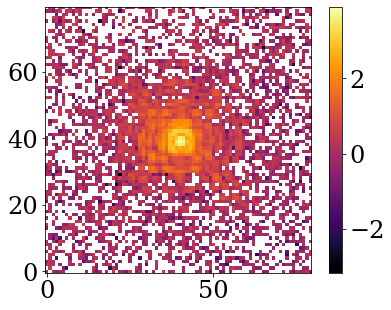

In [29]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

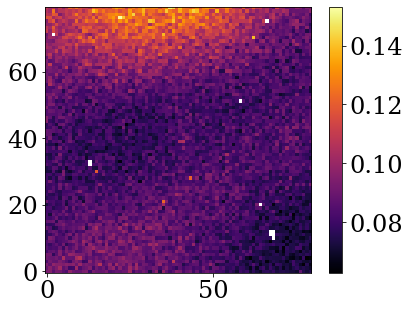

In [30]:
plt.imshow(exposures[0].err)
plt.colorbar()

In [31]:
params = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "cold_mask_scale": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0434735,
    "rot": 0.0
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.12, 0.12])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [32]:
params

ModelParams(
  params={
    'fluxes':
    {
      'n43ca5fjq':
      f32[],
      'n43ca5fkq':
      f32[],
      'n43ca5flq':
      f32[],
      'n43ca5fmq':
      f32[]
    },
    'positions':
    {
      'n43ca5fjq':
      f32[2],
      'n43ca5fkq':
      f32[2],
      'n43ca5flq':
      f32[2],
      'n43ca5fmq':
      f32[2]
    },
    'aberrations':
    {
      'n43ca5fjq':
      f32[19],
      'n43ca5fkq':
      f32[19],
      'n43ca5flq':
      f32[19],
      'n43ca5fmq':
      f32[19]
    },
    'cold_mask_shift':
    {
      'n43ca5fjq':
      f32[2],
      'n43ca5fkq':
      f32[2],
      'n43ca5flq':
      f32[2],
      'n43ca5fmq':
      f32[2]
    },
    'cold_mask_rot':
    {'n43ca5fjq': 45.0, 'n43ca5fkq': 45.0, 'n43ca5flq': 45.0, 'n43ca5fmq': 45.0},
    'cold_mask_scale':
    {
      'n43ca5fjq':
      f32[2],
      'n43ca5fkq':
      f32[2],
      'n43ca5flq':
      f32[2],
      'n43ca5fmq':
      f32[2]
    },
    'outer_radius':
    1.146,
    'secondary_radius':
  

In [33]:
print(params.params)

{'fluxes': {'n43ca5fjq': Array(3.797275, dtype=float32), 'n43ca5fkq': Array(3.779604, dtype=float32), 'n43ca5flq': Array(3.789861, dtype=float32), 'n43ca5fmq': Array(3.804248, dtype=float32)}, 'positions': {'n43ca5fjq': Array([0., 0.], dtype=float32), 'n43ca5fkq': Array([0., 0.], dtype=float32), 'n43ca5flq': Array([0., 0.], dtype=float32), 'n43ca5fmq': Array([0., 0.], dtype=float32)}, 'aberrations': {'n43ca5fjq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32), 'n43ca5fkq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32), 'n43ca5flq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32), 'n43ca5fmq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'cold_mask_shift': {'n43ca5fjq': Array([12., 12.], dtype=float32), 'n43ca5fkq': Array([12., 12.], dtype=float32), '

In [34]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "fluxes" : opt(g*50,10),
    "positions": opt(g*50, 0),
    "cold_mask_shift": opt(g*500, 50),
    #"cold_mask_rot": opt(g*100, 50),
    #"scale": opt(g*8, 20),
    "cold_mask_scale": opt(g*100, 50),
    "aberrations": opt(g*1.5,25),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [35]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [36]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
lrs.params

{'aberrations': {'n43ca5fjq': Array([0.00039584, 0.0001748 , 0.00015041, 0.00030094, 0.00028946,
         0.00041993, 0.00039496, 0.00047323, 0.00016362, 0.00020535,
         0.00027692, 0.00023029, 0.0002681 , 0.00028915, 0.00023476,
         0.00023956, 0.00028709, 0.00027801, 0.00021446], dtype=float32),
  'n43ca5fkq': Array([0.00068364, 0.00028894, 0.0002249 , 0.00106095, 0.0005904 ,
         0.00107945, 0.00099768, 0.00074654, 0.0002543 , 0.00035964,
         0.00038806, 0.00031929, 0.00038288, 0.00047966, 0.00041341,
         0.00042066, 0.0003904 , 0.00038342, 0.00031151], dtype=float32),
  'n43ca5flq': Array([0.00097293, 0.00044611, 0.00036013, 0.00114481, 0.00536856,
         0.00402505, 0.00527399, 0.00116696, 0.00041924, 0.0005624 ,
         0.00061901, 0.00051968, 0.00103288, 0.00054975, 0.00075785,
         0.00071345, 0.00064934, 0.00062995, 0.00049908], dtype=float32),
  'n43ca5fmq': Array([0.00034863, 0.00019654, 0.00017408, 0.00035229, 0.00035298,
         0.00044532, 

In [38]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/120 [00:00<?, ?it/s]

In [39]:
#model


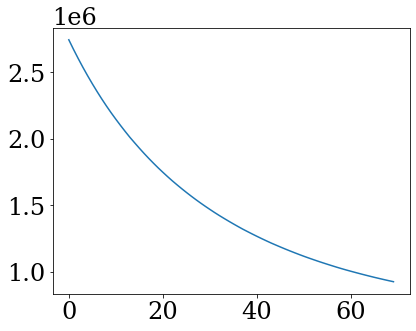

In [40]:
plt.plot(losses[50:])

In [41]:
params.params

{'aberrations': {'n43ca5fjq': Array([  0.02916088,  -0.02058641,   0.0840032 , -18.478292  ,
           9.253957  ,   4.3635983 ,  -3.3522458 ,  -4.910895  ,
           4.4898987 ,  -0.51357734,  -1.1223798 ,  -0.57423407,
          -3.9252114 ,   9.010887  ,   2.4668126 ,  -1.0045668 ,
           1.3812374 ,  -2.313956  ,  -0.38861877], dtype=float32),
  'n43ca5fkq': Array([ -0.40799022,  -0.15389588,  -0.03757631, -28.417887  ,
          13.22708   ,  11.130075  ,  -1.2681638 ,  -1.294619  ,
           4.6980515 ,   1.2666042 ,  -0.92462015,   0.09251301,
          -3.467534  ,   6.4212375 ,   0.4906732 ,  -3.3164315 ,
           1.1698439 ,  -1.7851598 ,   0.22315581], dtype=float32),
  'n43ca5flq': Array([-2.3327345e-01, -1.0801286e-01, -5.8129048e-01, -2.4698948e+01,
          1.7645760e+01,  1.0774218e+01,  2.5061855e-01, -8.5979910e+00,
          4.2018733e+00, -2.0264881e+00, -1.9344917e-02,  9.6678115e-02,
         -3.3540864e+00,  5.9029608e+00,  7.0379168e-01, -1.2023877e+00

5


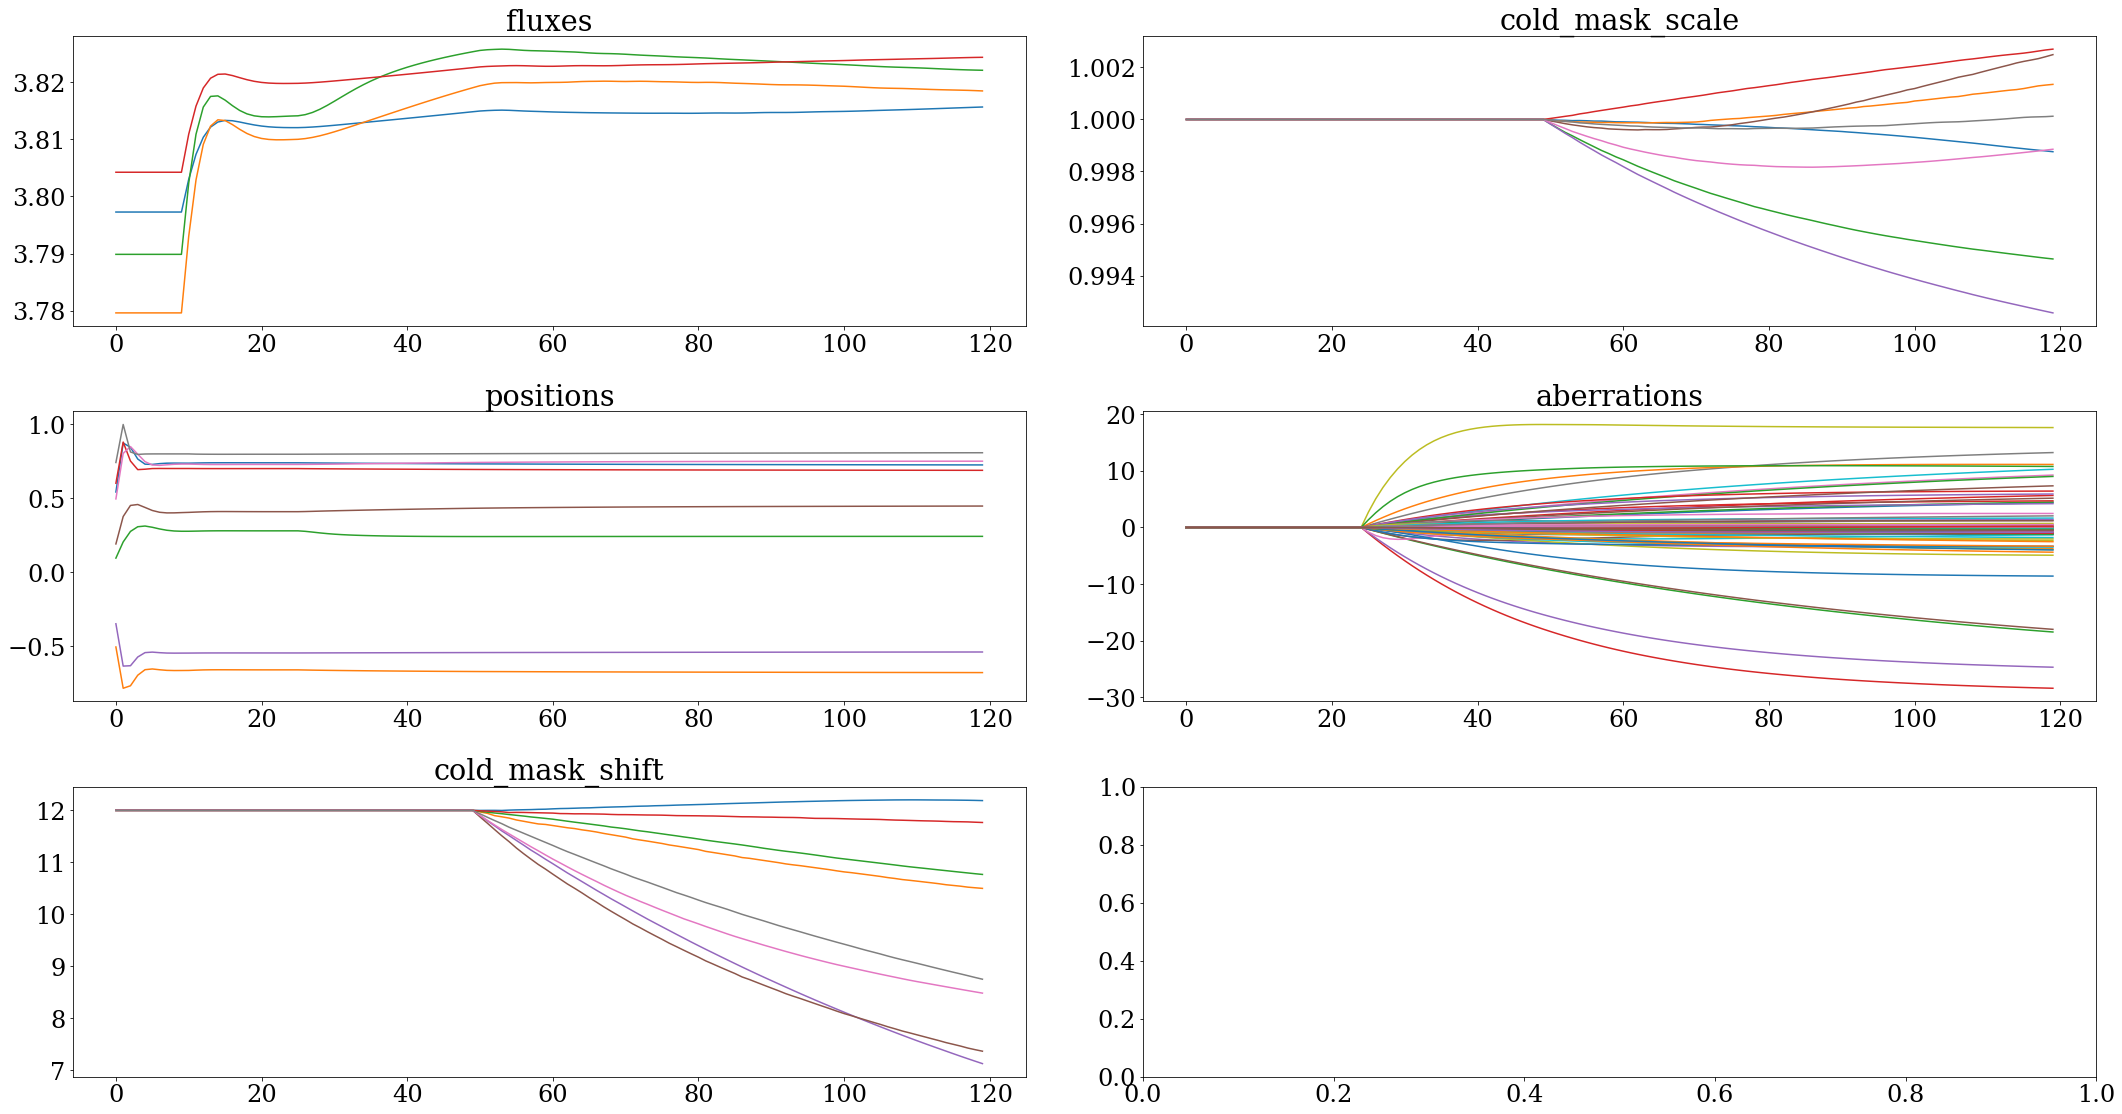

In [42]:
xw = 3
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot", "cold_mask_scale"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

2.027005e+08, 9.233198e+05


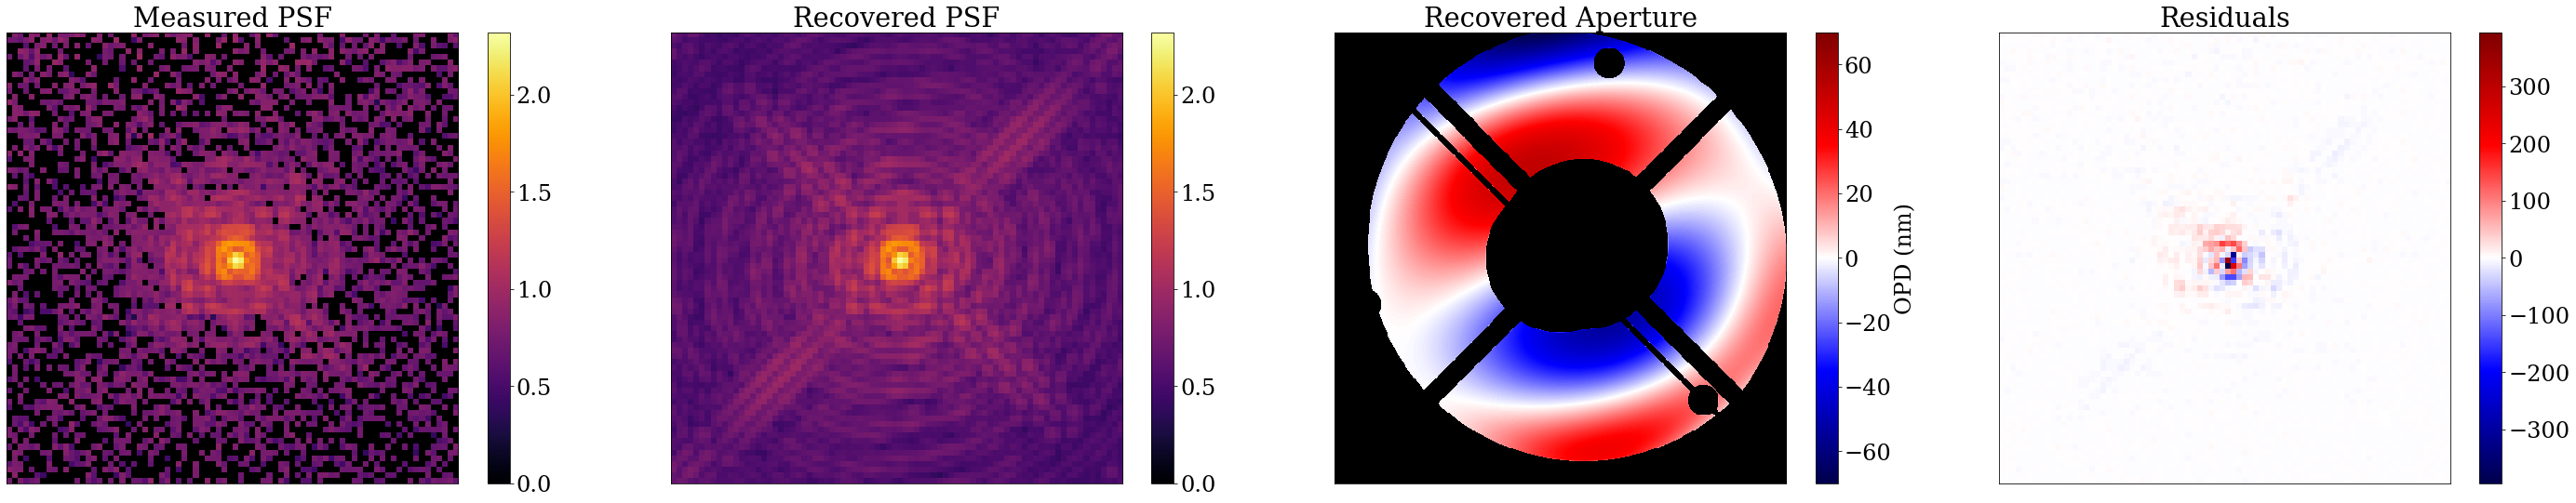

In [51]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [44]:
resid = (exp.data - exp.fit(model,exp))/exp.err
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

In [45]:
np.sort(resid.flatten())[::-1][:50]

Array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 210.05106 , 154.59235 ,
       143.92883 , 115.92271 , 115.30581 , 102.60928 , 100.64505 ,
        95.27421 ,  95.212006,  93.14328 ,  86.75594 ,  67.34374 ,
        65.49112 ,  64.499695,  60.872177,  60.161495,  57.791237,
        54.134148,  53.3107  ,  51.352962,  50.34242 ,  48.6542  ,
        46.394325,  46.119648,  45.79311 ,  43.619633,  42.38246 ,
        42.12072 ,  36.23512 ,  34.96963 ,  33.879147,  32.0828  ,
        28.941122,  26.77055 ,  26.152905,  26.036753,  25.856789,
        25.30321 ,  23.534883,  22.368694,  21.831034,  21.072937],      dtype=float32)

In [46]:
if new_nans:
    nanmap = np.ones((wid,wid))
    for i in tqdm(range(10)):
        lpdf = posterior(model,exp,return_im=True)*nanmap
        ind = np.unravel_index(np.nanargmax(lpdf),lpdf.shape)
        nanmap = nanmap.at[ind].set(np.nan)

    

    bad = np.isnan(lpdf)

  0%|          | 0/10 [00:00<?, ?it/s]

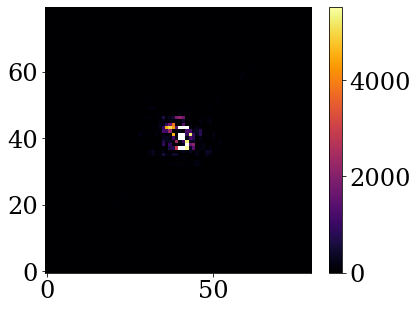

In [47]:
lpdf = posterior(model,exp,return_im=True)*nanmap
plt.imshow(lpdf)
plt.colorbar()

In [48]:
"""fig, axs = plt.subplots(1,3, figsize=(32,8))
fig.tight_layout()

cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)


model = ModelParams(injected_params).inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_t = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_t))
apt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")

model = params.inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_r = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_r))
apt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")

resid = opd_t - opd_r
olim = np.max(np.abs(resid))
apt =axs[2].imshow(resid,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("residual (nm)")
axs[2].set_title("Aberration Residuals")
axs[1].set_title("Recovered Aberrations")
axs[0].set_title("Injected Aberrations")

"""


'fig, axs = plt.subplots(1,3, figsize=(32,8))\nfig.tight_layout()\n\ncmap = matplotlib.colormaps[\'seismic\']\ncmap.set_bad(\'k\',1)\n\n\nmodel = ModelParams(injected_params).inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_t = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_t))\napt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")\n\nmodel = params.inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_r = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_r))\napt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")\n\nresid = opd_t - opd_r\nolim = np.max(np.abs(resid))\napt =

In [49]:
params.params

{'aberrations': {'n43ca5fjq': Array([  0.02916088,  -0.02058641,   0.0840032 , -18.478292  ,
           9.253957  ,   4.3635983 ,  -3.3522458 ,  -4.910895  ,
           4.4898987 ,  -0.51357734,  -1.1223798 ,  -0.57423407,
          -3.9252114 ,   9.010887  ,   2.4668126 ,  -1.0045668 ,
           1.3812374 ,  -2.313956  ,  -0.38861877], dtype=float32),
  'n43ca5fkq': Array([ -0.40799022,  -0.15389588,  -0.03757631, -28.417887  ,
          13.22708   ,  11.130075  ,  -1.2681638 ,  -1.294619  ,
           4.6980515 ,   1.2666042 ,  -0.92462015,   0.09251301,
          -3.467534  ,   6.4212375 ,   0.4906732 ,  -3.3164315 ,
           1.1698439 ,  -1.7851598 ,   0.22315581], dtype=float32),
  'n43ca5flq': Array([-2.3327345e-01, -1.0801286e-01, -5.8129048e-01, -2.4698948e+01,
          1.7645760e+01,  1.0774218e+01,  2.5061855e-01, -8.5979910e+00,
          4.2018733e+00, -2.0264881e+00, -1.9344917e-02,  9.6678115e-02,
         -3.3540864e+00,  5.9029608e+00,  7.0379168e-01, -1.2023877e+00

In [50]:
np.log10(list(params.params["fluxes"].values())[0])

Array(0.58157164, dtype=float32)